# 1. Importing Packages

In [378]:
# importing shit
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

In [379]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [380]:
!pip install ta


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [381]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mira/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [382]:
import ta

# 2. Preparing Data

**2.a Get Stock Data**

<Axes: xlabel='Date'>

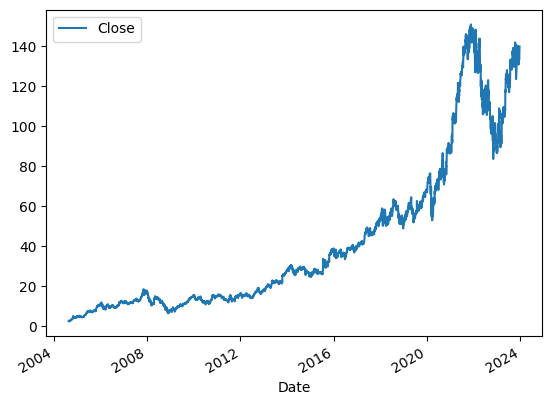

In [383]:
data = yf.Ticker("GOOG")
data = data.history(period = "max")
data.plot.line(y = "Close", use_index = True) 

In [384]:
data["Adjusted Close"] = data["Close"] - data["Dividends"]
del data["Dividends"]
del data["Stock Splits"]
data["Tomorrow"] = data["Adjusted Close"].shift(-1)
data["Target"] = (data["Tomorrow"] > data["Adjusted Close"]).astype(int)

In [385]:
data = data.loc["2004-01-01":].copy()
data

,Open,High,Low,Close,Volume,Adjusted Close,Tomorrow,Target
Date,,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,2.499133,2.697639,1
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,2.697639,2.724787,1
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,2.724787,2.611960,0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,2.611960,2.640104,1
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,2.640104,2.687676,1
...,...,...,...,...,...,...,...,...
2023-12-14 00:00:00-05:00,134.770004,135.035004,131.059998,133.199997,29619100,133.199997,133.839996,1
2023-12-15 00:00:00-05:00,132.919998,134.830002,132.630005,133.839996,58569400,133.839996,137.190002,1
2023-12-18 00:00:00-05:00,133.860001,138.380005,133.770004,137.190002,25699800,137.190002,138.100006,1


**2.b Calculate Technical Indicator**

In [386]:
# Technical indicators compute

# Moving averages
data['sma'] = ta.trend.sma_indicator(data['Adjusted Close'])
data['ema'] = ta.trend.ema_indicator(data['Adjusted Close'])

# MACD
macd = ta.trend.MACD(data['Adjusted Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

# RSI
data['RSI'] = ta.momentum.rsi(data['Adjusted Close'])

# Bollinger Bands
bol = ta.volatility.BollingerBands(data['Adjusted Close'])
data['bollinger_high'] = bol.bollinger_hband()
data['bollinger_low'] = bol.bollinger_lband()

# Stochastic Oscillator
stochastic = ta.momentum.StochasticOscillator(high = data['High'], low = data['Low'], close = data['Adjusted Close'])
data['stochastic_oscillator'] = stochastic.stoch()

# Average True Range
data['ATR'] = ta.volatility.average_true_range(high = data['High'], low = data['Low'], close = data['Adjusted Close'])

# Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high = data['High'], low = data['Low'])
data['ichimoku_a'] = ichimoku.ichimoku_a()
data['ichimoku_b'] = ichimoku.ichimoku_b()

# Pivot Points
data['pivot_point'] = (data['High'] + data['Low'] + data['Adjusted Close']) / 3
data['pivot_support'] = (2 * data['pivot_point']) - data['High']
data['pivot_resistance'] = (2 * data['pivot_point']) - data['Low']


In [387]:
# Cleaning data - dropping any missing values
data = data.dropna()

# Features-target split
X = data.drop(columns=['Adjusted Close'])
y = data['Adjusted Close']

# Random forest to compute features
model = RandomForestRegressor()
model.fit(X, y)

# Identify features that have more importance than the mean
selector = SelectFromModel(model, prefit=True)
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]

# Dataframe only to include the selected features and the target variable
data_selected = data[selected_features].join(data['Adjusted Close'])

data = data.dropna()


/Users/mira/Desktop/Coding/ML/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


**2.c Sentiment Analysis on data**

In [388]:
# Sentiment Analysis 
url = "https://finviz.com/quote.ashx?t=GOOG&p=d"
request = Request(url = url, headers = {'user-agent' : 'my-app'})
text = urlopen(request)
text = BeautifulSoup(text, 'html')

In [389]:
news_tables = text.find(id = 'news-table')
news_rows = news_tables.findAll('tr')
date = 0
processed_data = []
for index, row in enumerate(news_rows):
    if row.a:
        timestamp = row.td.text.strip().split()
        title = row.a.text.strip()
        link = row.a.get('href')
        if len(timestamp) == 2:
            date = timestamp[0]
            time = timestamp[1]
            if date == "Today":
                date = "Dec-16-23"
        else:
            time = timestamp[0]
        processed_data.append([date, time, title, link])

In [390]:
df = pd.DataFrame(processed_data, columns = ['date', 'time', 'title', 'link'])
df['date'] = pd.to_datetime(df.date).dt.date
df

/var/folders/b9/h9nqxxq56r11l_79dklxps7r0000gn/T/ipykernel_64334/829778843.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df.date).dt.date


,date,time,title,link
0,2023-12-16,08:17PM,"Anthropic in Talks to Raise $750 Million, Led ...",https://finance.yahoo.com/news/anthropic-talks...
1,2023-12-16,07:04PM,Alphabet Stock Climbed Again Today Thanks to A...,https://finance.yahoo.com/m/b98ce867-f1c8-30c4...
2,2023-12-16,05:45PM,Alphabet Inc. (GOOG) Rises As Market Takes a D...,https://finance.yahoo.com/news/alphabet-inc-go...
3,2023-12-16,04:20PM,Google Rises On Reported Digital Ad Business R...,https://finance.yahoo.com/m/ec3cf4f9-9208-3431...
4,2023-12-16,03:58PM,"Nvidia, Tesla, Meta Reveal Rules For Santa Cla...",https://finance.yahoo.com/m/26c770ad-a814-3731...
...,...,...,...,...
95,2023-12-16,08:00AM,AI is exposing awkward ties on Meta and Micros...,https://finance.yahoo.com/news/ai-exposing-awk...
96,2023-12-16,07:30AM,Top AI stock picks for 2024: Two analysts shar...,https://finance.yahoo.com/video/top-ai-stock-p...
97,2023-12-16,07:30AM,Here Are My Top 10 Stocks for 2024,https://finance.yahoo.com/m/b6f5a7e4-b066-3bb6...
98,2023-12-16,06:00AM,2 of This Year's Top Performers You'll Regret ...,https://finance.yahoo.com/m/25c1ddea-4199-3fdf...


In [391]:
vader = SentimentIntensityAnalyzer()
scores = []
for index, row in df.iterrows():
    title = row['title']
    url = row['link']
    request = Request(url = url, headers = {'user-agent' : 'my-app'})
    text = urlopen(request)
    soup = BeautifulSoup(text, 'html')
    text = soup.find('div', {'class' : 'caas-body'})
    if text:
        scores.append(vader.polarity_scores(text.text))
    else:
        scores.append(vader.polarity_scores(title))

In [392]:
df['sentiment_scores'] = [score['compound'] for score in scores]
df

,date,time,title,link,sentiment_scores
0,2023-12-16,08:17PM,"Anthropic in Talks to Raise $750 Million, Led ...",https://finance.yahoo.com/news/anthropic-talks...,0.9671
1,2023-12-16,07:04PM,Alphabet Stock Climbed Again Today Thanks to A...,https://finance.yahoo.com/m/b98ce867-f1c8-30c4...,0.9957
2,2023-12-16,05:45PM,Alphabet Inc. (GOOG) Rises As Market Takes a D...,https://finance.yahoo.com/news/alphabet-inc-go...,0.9934
3,2023-12-16,04:20PM,Google Rises On Reported Digital Ad Business R...,https://finance.yahoo.com/m/ec3cf4f9-9208-3431...,0.4767
4,2023-12-16,03:58PM,"Nvidia, Tesla, Meta Reveal Rules For Santa Cla...",https://finance.yahoo.com/m/26c770ad-a814-3731...,0.5859
...,...,...,...,...,...
95,2023-12-16,08:00AM,AI is exposing awkward ties on Meta and Micros...,https://finance.yahoo.com/news/ai-exposing-awk...,0.9791
96,2023-12-16,07:30AM,Top AI stock picks for 2024: Two analysts shar...,https://finance.yahoo.com/video/top-ai-stock-p...,0.9977
97,2023-12-16,07:30AM,Here Are My Top 10 Stocks for 2024,https://finance.yahoo.com/m/b6f5a7e4-b066-3bb6...,0.9995
98,2023-12-16,06:00AM,2 of This Year's Top Performers You'll Regret ...,https://finance.yahoo.com/m/25c1ddea-4199-3fdf...,0.9992


<Figure size 1000x800 with 0 Axes>

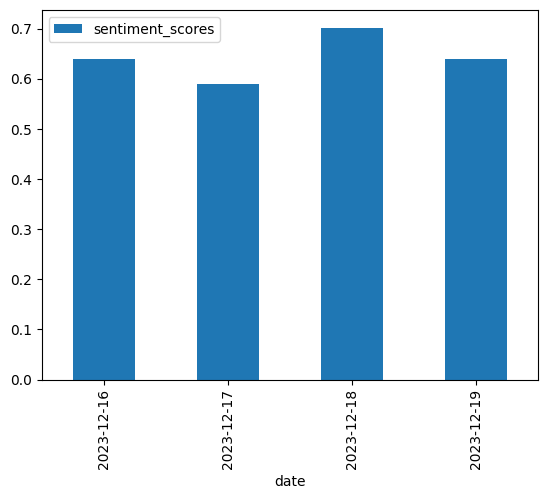

In [393]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

mean_df = df.groupby('date')[numeric_columns].mean()

plt.figure(figsize = (10,8))
mean_df.plot(kind = 'bar')
plt.show()

In [394]:
# Final data table
data.describe()

,Open,High,Low,Close,Volume,Adjusted Close,Tomorrow,Target,sma,ema,...,RSI,bollinger_high,bollinger_low,stochastic_oscillator,ATR,ichimoku_a,ichimoku_b,pivot_point,pivot_support,pivot_resistance
count,4835.000000,4835.000000,4835.000000,4835.000000,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,...,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,41.933874,42.378693,41.508436,41.952026,1.179230e+08,41.952026,41.980205,0.522441,41.801767,41.801679,...,54.251609,44.009921,39.375900,57.198220,0.958659,41.666986,41.175786,41.946385,41.514077,42.384334
std,38.779640,39.223935,38.382026,38.809450,1.507506e+08,38.809450,38.830920,0.499548,38.677678,38.667449,...,12.540261,40.802968,36.429653,30.649390,1.021688,38.519335,38.047619,38.803730,38.386698,39.228307
min,3.348449,3.427403,3.322546,3.368873,1.584340e+05,3.368873,3.368873,0.000000,3.166797,3.194872,...,21.330543,3.522959,2.492518,0.000000,0.106483,3.074725,2.920179,3.387055,3.315572,3.440355
25%,12.951331,13.112351,12.827296,12.970882,2.832100e+07,12.970882,12.975490,0.000000,12.963213,12.969272,...,45.000985,13.707427,12.045822,30.138544,0.282478,12.916585,12.994419,12.960130,12.847262,13.114344
50%,26.646841,26.860001,26.431433,26.652824,5.972800e+07,26.652824,26.666500,1.000000,26.699509,26.747072,...,53.971151,27.567698,25.517376,61.224480,0.468909,26.786688,26.903886,26.672520,26.454037,26.872608
75%,57.893999,58.655251,57.327625,58.108252,1.455716e+08,58.108252,58.117001,1.000000,57.700896,57.817862,...,63.353255,60.964993,54.187968,86.014709,1.153525,58.160225,57.856750,58.083975,57.402107,58.632733
max,151.863495,152.100006,149.887497,150.709000,1.650833e+09,150.709000,150.709000,1.000000,148.977584,148.561468,...,90.929431,153.767702,144.538475,100.000000,4.788934,146.443378,144.299255,150.563334,149.276662,151.879832


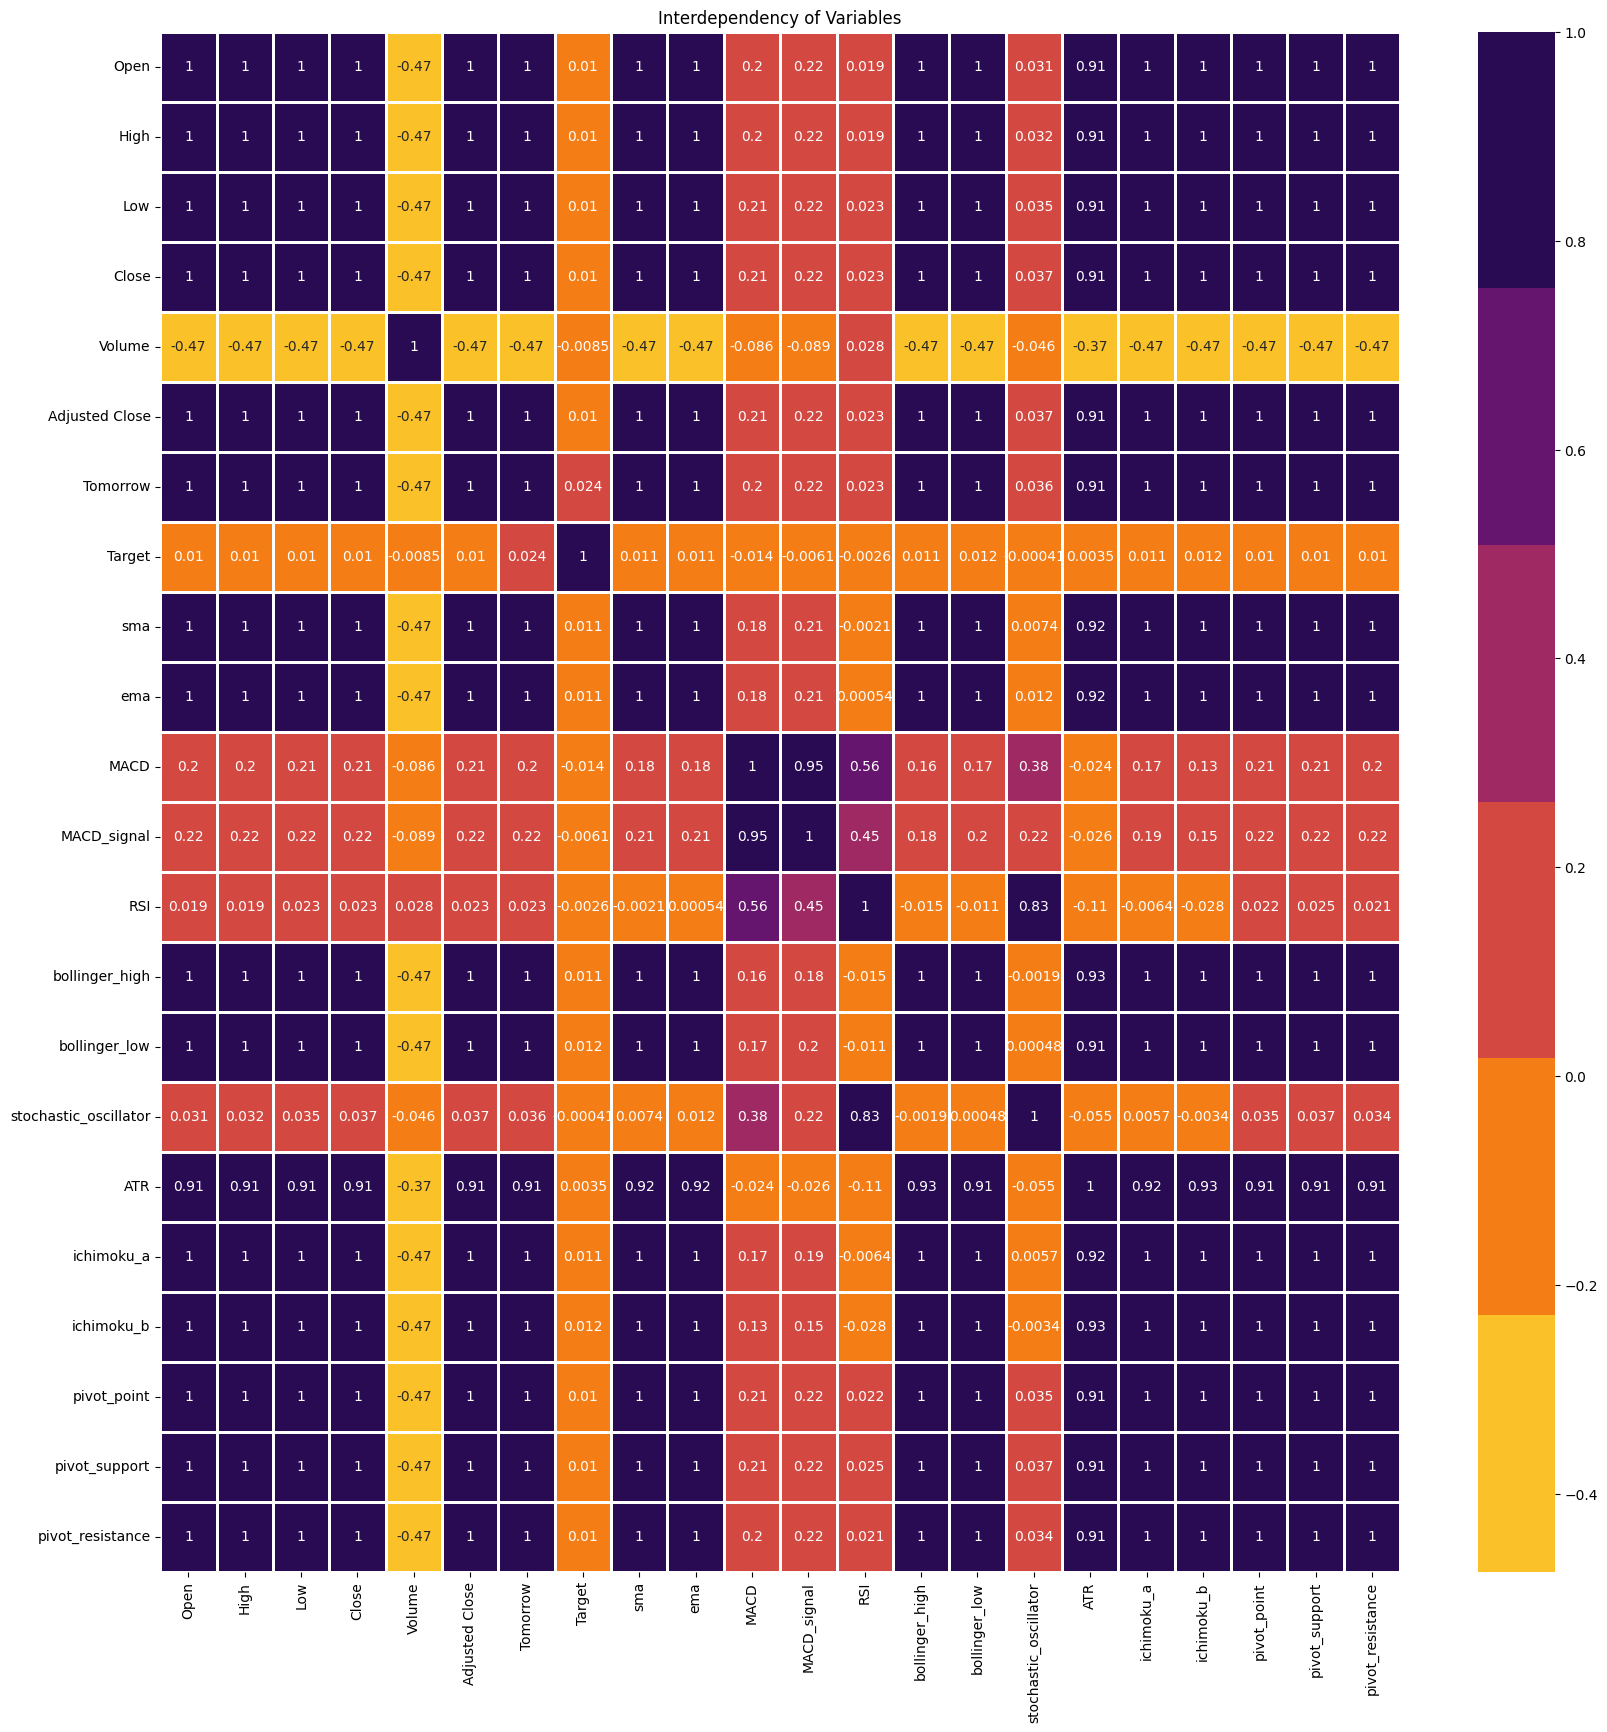

In [395]:
correlation = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("inferno_r"),
            linewidth=1,edgecolor="k")
plt.title("Interdependency of Variables")
plt.show()

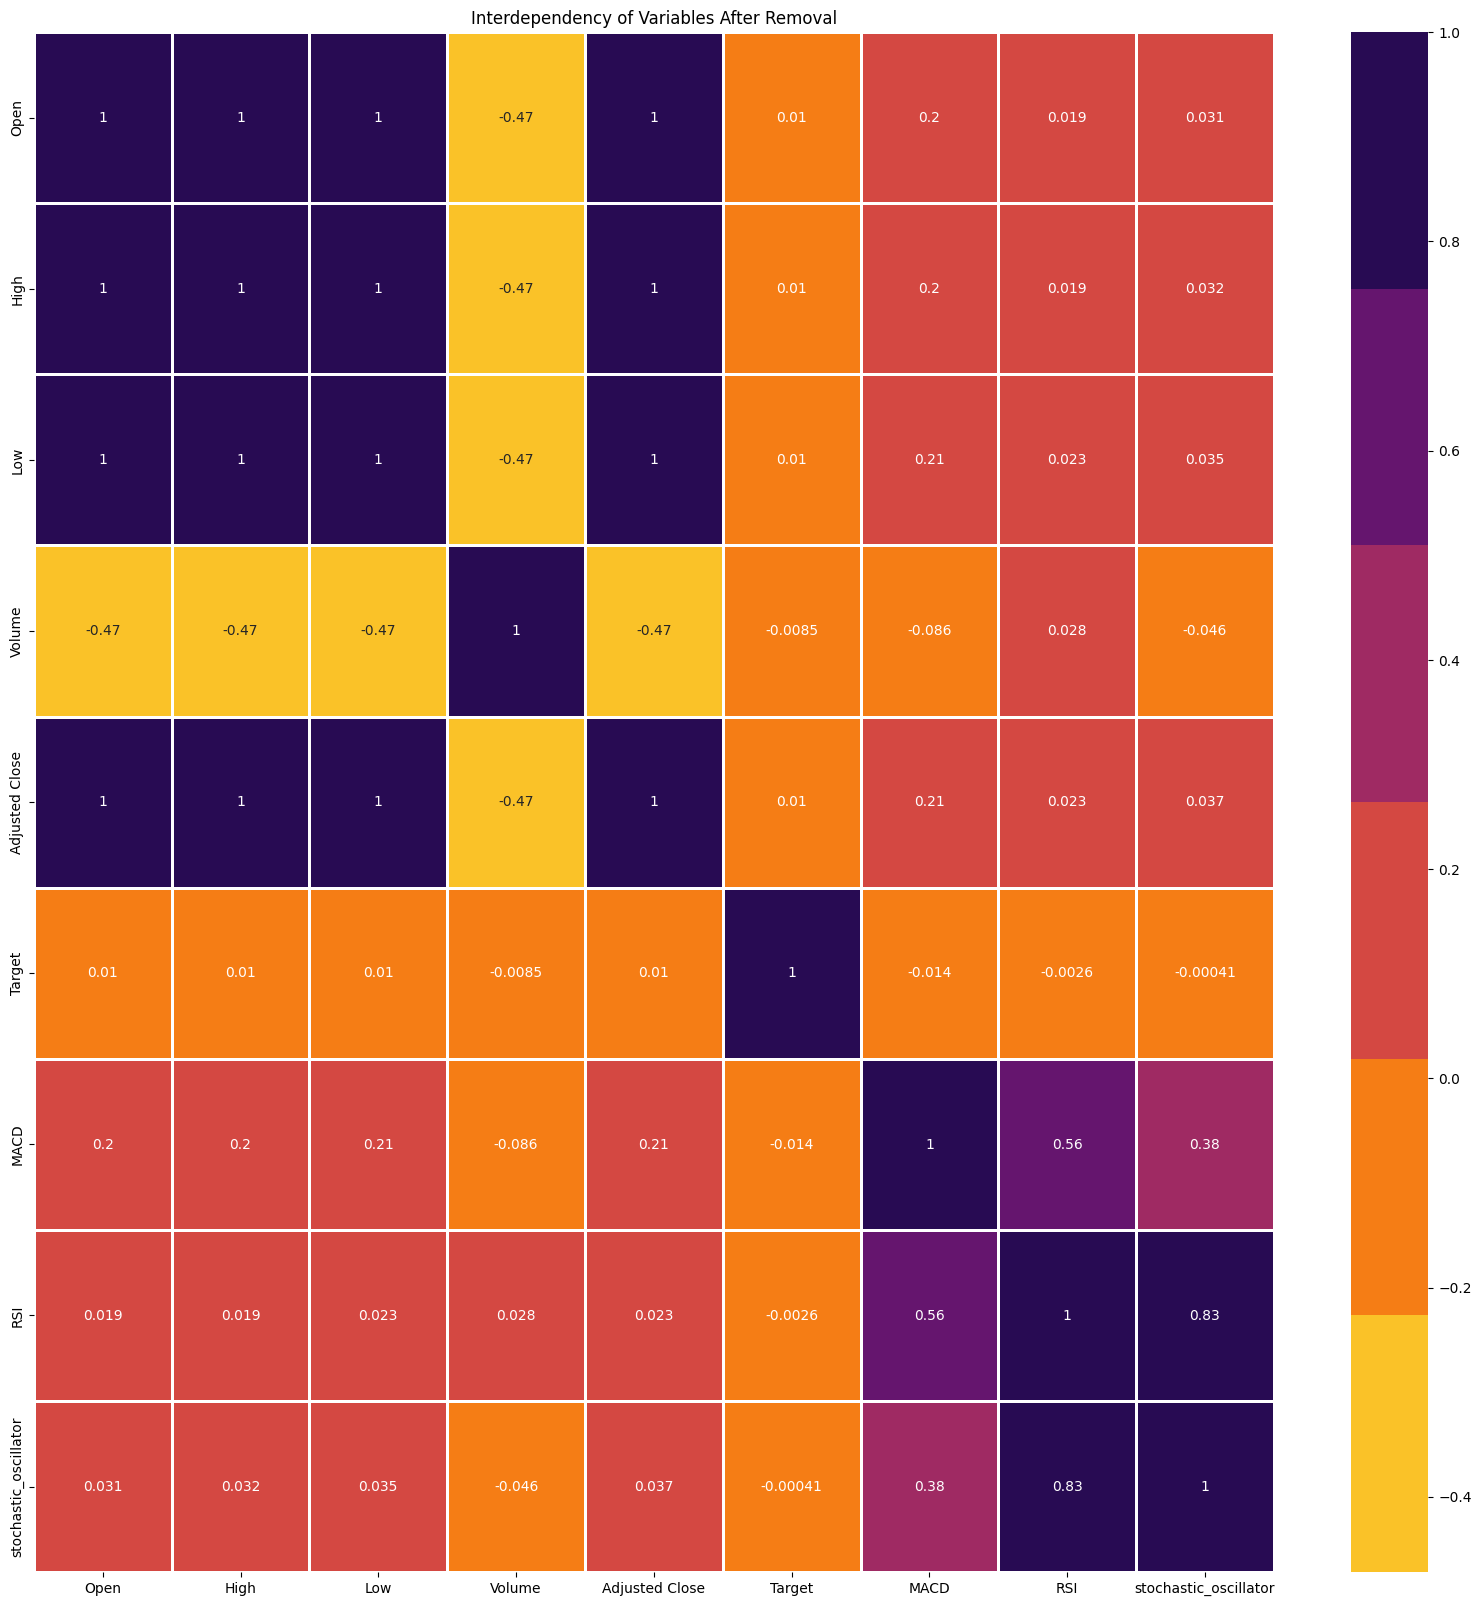

In [396]:
# Set the threshold for high correlation.
threshold = 0.9

# List of variables to exclude from removal
excluded_vars = ['Adjusted Close', 'High', 'Low']

# Identify the variables that are highly correlated and not in the exclusion list
correlated_features = set()
for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > threshold and correlation.columns[i] not in excluded_vars:
            colname = correlation.columns[i]
            correlated_features.add(colname)

# Remove the identified features, except for the excluded ones
data = data.drop(columns=list(correlated_features - set(excluded_vars)))

# Rerun correlation matrix to check new correlations
correlation = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, cmap=sns.color_palette("inferno_r"), linewidth=1, edgecolor="k")
plt.title("Interdependency of Variables After Removal")
plt.show()


# 3. Pre-process Data

In [397]:
# training and testing split
X = np.array(data.drop(columns=['Adjusted Close'])) # features
y = np.array(data['Adjusted Close']) # target

# scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [398]:
# 95% PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [399]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)


X_train.shape:  (3868, 5)
y_train.shape:  (3868,)


In [400]:
# Variables to hold results for all ML models
max_accuracy = []

# 4. Linear Regression Models

**4.1 Linear Regression + L1 Regularization**

In [401]:
alpha = [0.2, 0.5, 1]
# no alphas below 1 allowed due to absurdly high fit (0.999+); ridge, PCA, etc not enough
accuracy = []
validation_scores = []
train_scores = []
test_scores = []
y_preds = []

In [402]:
def linearRegression(a , X_train, y_train, X_test, y_test):
    # Create an object of logistic regression model using linear_model.
  
    reg = linear_model.Lasso(alpha= a, warm_start=True,  max_iter = 5000)
    reg.fit(X_train, y_train)
    
    # Calculating what for train and test
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)
    
    # Calculating accuracy
    accuracy_val = r2_score(y_test, y_pred)
    validation_score = np.mean(cross_val_score(reg, X_train, y_train, cv=5))
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    validation_scores.append(validation_score)
    accuracy.append(accuracy_val)
    
    # Printing values 
    print("For alpha = %f" % a)
    print("Accuracy on test data = %f" % accuracy_val)
    print("Validation Score = %f" % validation_score)
    print("Train Score = %f" % train_score)
    print("Test Score = %f" % test_score)

In [403]:
for i in alpha:
    linearRegression(i, X_train, y_train, X_test, y_test)  
    print()

For alpha = 0.200000
Accuracy on test data = 0.999672
Validation Score = 0.999670
Train Score = 0.999674
Test Score = 0.999672

For alpha = 0.500000
Accuracy on test data = 0.999073
Validation Score = 0.999114
Train Score = 0.999130
Test Score = 0.999073

For alpha = 1.000000
Accuracy on test data = 0.996939
Validation Score = 0.997135
Train Score = 0.997185
Test Score = 0.996939



**4.2 Hyperparameter Optimization - Lasso**

In [404]:
reg = linear_model.Lasso(warm_start=True,  max_iter = 5000)
grid = GridSearchCV(estimator = reg, param_grid= dict(alpha= alpha), scoring= 'r2', cv= 5)
grid.fit(X_train, y_train)
print(f"Best Alpha: {grid.best_estimator_.alpha}")

# Predict using the best model
y_pred = grid.predict(X_test)

# Calculate accuracy and scores
accuracy_val = r2_score(y_test, y_pred)
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

# Print values
print("Accuracy on test data:", accuracy_val)
print("Train Score:", train_score)
print("Test Score:", test_score)


Best Alpha: 0.2
Accuracy on test data: 0.9996721782839617
Train Score: 0.9996741189098598
Test Score: 0.9996721782839617


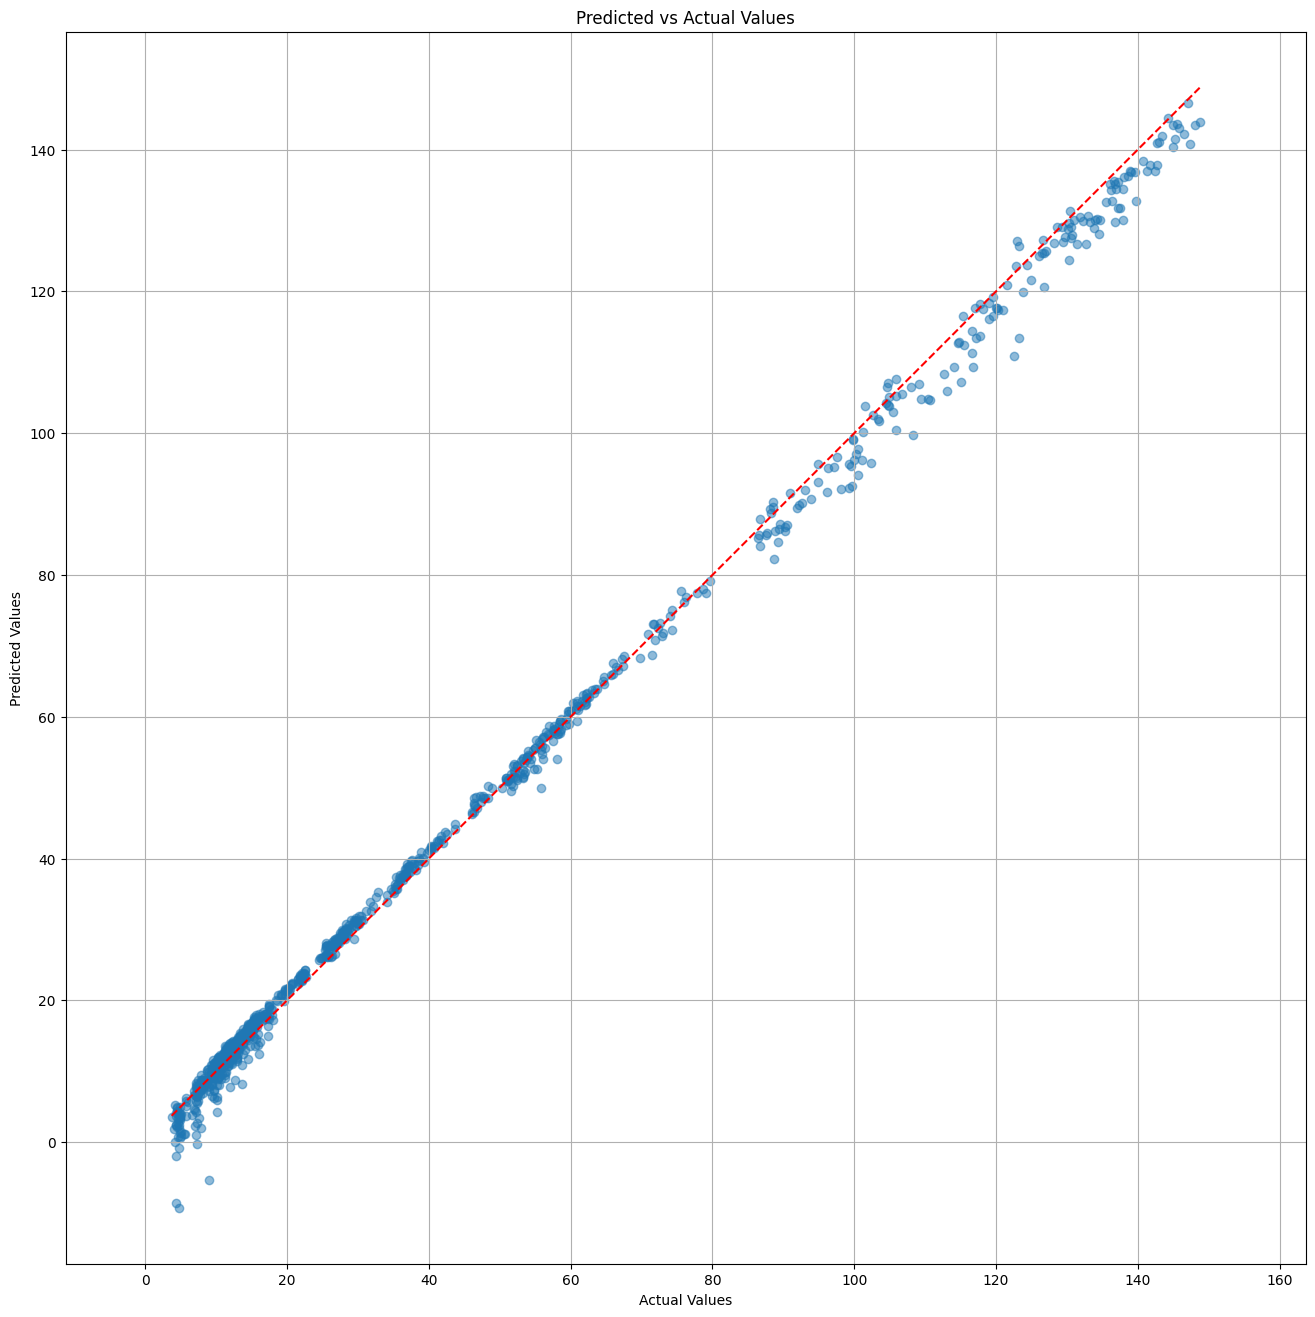

In [405]:
import matplotlib.pyplot as plt
y_pred = y_preds[2]
plt.figure(figsize=(16, 16))
plt.scatter(y_test, y_pred, alpha=0.5)  # plot the predictions vs the actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # plot a 45-degree reference line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.axis('equal')  # Set equal scaling by changing axis limits
plt.show()

[0.2, 0.5, 1]
[0.9996741189098598, 0.9991296640387317, 0.9971851782612277]
[0.9996698085683337, 0.9991140942500193, 0.9971354789120224]
[0.9996721782839617, 0.9990730843947114, 0.9969393264202896]


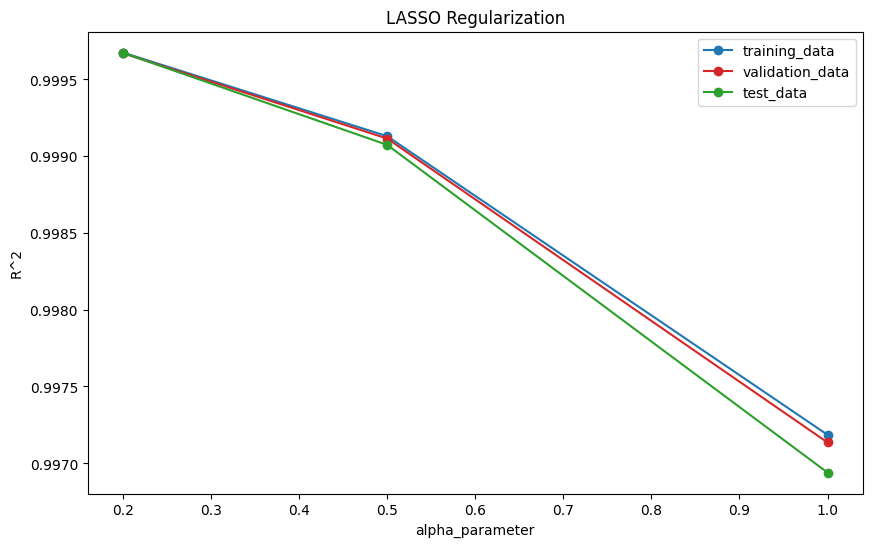

In [406]:
plt.figure(figsize=(10, 6))
print(alpha)
print(train_scores)
print(validation_scores)
print(test_scores)
plt.plot(alpha, train_scores, label='training_data', marker='o', linestyle='-', color = "tab:blue")
plt.plot(alpha, validation_scores, label='validation_data', marker='o', linestyle='-', color = "tab:red")
plt.plot(alpha, test_scores, label='test_data', marker='o', linestyle='-', color = "tab:green")

plt.xlabel('alpha_parameter')
plt.ylabel('R^2')
plt.title('LASSO Regularization')
plt.legend()
plt.show()

**4.3 Linear Regression + L2 Regularization**

In [412]:
alpha = [0.2, 0.5, 1]
accuracy = []
validation_scores = []
train_scores = []
test_scores = []
y_preds = []

In [413]:
def linearRegression(a , X_train, y_train, X_test, y_test):
    # Create an object of logistic regression model using linear_model.

    reg = linear_model.Ridge(alpha= a, solver= 'saga', random_state = 42, max_iter = 5000)
    reg.fit(X_train, y_train)

    # Calculating yhat for train and test
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)

    # Calculating accuracy
    accuracy_val = r2_score(y_test, y_pred)
    validation_score = np.mean(cross_val_score(reg, X_train, y_train, cv=5))
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    validation_scores.append(validation_score)
    accuracy.append(accuracy_val)

    # Printing values
    print("For alpha = %f" % a)
    print("Accuracy on test data = %f" % accuracy_val)
    print("Validation Score = %f" % validation_score)
    print("Train Score = %f" % train_score)
    print("Test Score = %f" % test_score)

In [414]:
for i in alpha:
    linearRegression(i, X_train, y_train, X_test, y_test)
    print()

For alpha = 0.200000
Accuracy on test data = 0.999812
Validation Score = 0.999802
Train Score = 0.999803
Test Score = 0.999812

For alpha = 0.500000
Accuracy on test data = 0.999812
Validation Score = 0.999802
Train Score = 0.999803
Test Score = 0.999812

For alpha = 1.000000
Accuracy on test data = 0.999812
Validation Score = 0.999802
Train Score = 0.999803
Test Score = 0.999812



[0.9998031236858107, 0.9998031221138279, 0.9998031154404949]
[0.9998018569643412, 0.9998018496924633, 0.9998018291005077]
[0.9998118514722686, 0.9998117892518626, 0.9998116814311399]


<Figure size 640x480 with 0 Axes>

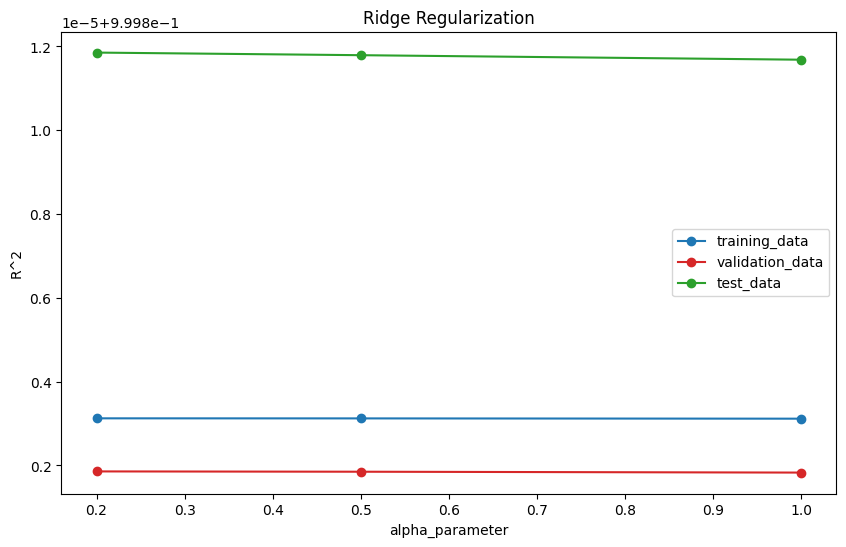

In [428]:
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(alpha, train_scores, label='training_data', marker='o', linestyle='-', color = "tab:blue")
plt.plot(alpha, validation_scores, label='validation_data', marker='o', linestyle='-', color = "tab:red")
plt.plot(alpha, test_scores, label='test_data', marker='o', linestyle='-', color = "tab:green")

print(train_scores)
print(validation_scores)
print(test_scores)

plt.xlabel('alpha_parameter')
plt.ylabel('R^2')
plt.title('Ridge Regularization')
plt.legend()
plt.show()

In [415]:
reg = linear_model.Ridge(solver= 'saga', random_state = 42, max_iter = 5000)
grid = GridSearchCV(estimator = reg, param_grid= dict(alpha= alpha), scoring= 'r2', cv= 5)
grid.fit(X_train, y_train)
print(f"Best Alpha: {grid.best_estimator_.alpha}")

# Predict using the best model
y_pred = grid.predict(X_test)

# Calculate accuracy and scores
accuracy_val = r2_score(y_test, y_pred)
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

# Print values
print("Accuracy on test data:", accuracy_val)
print("Train Score:", train_score)
print("Test Score:", test_score)

Best Alpha: 0.2
Accuracy on test data: 0.9998118514722686
Train Score: 0.9998031236858107
Test Score: 0.9998118514722686


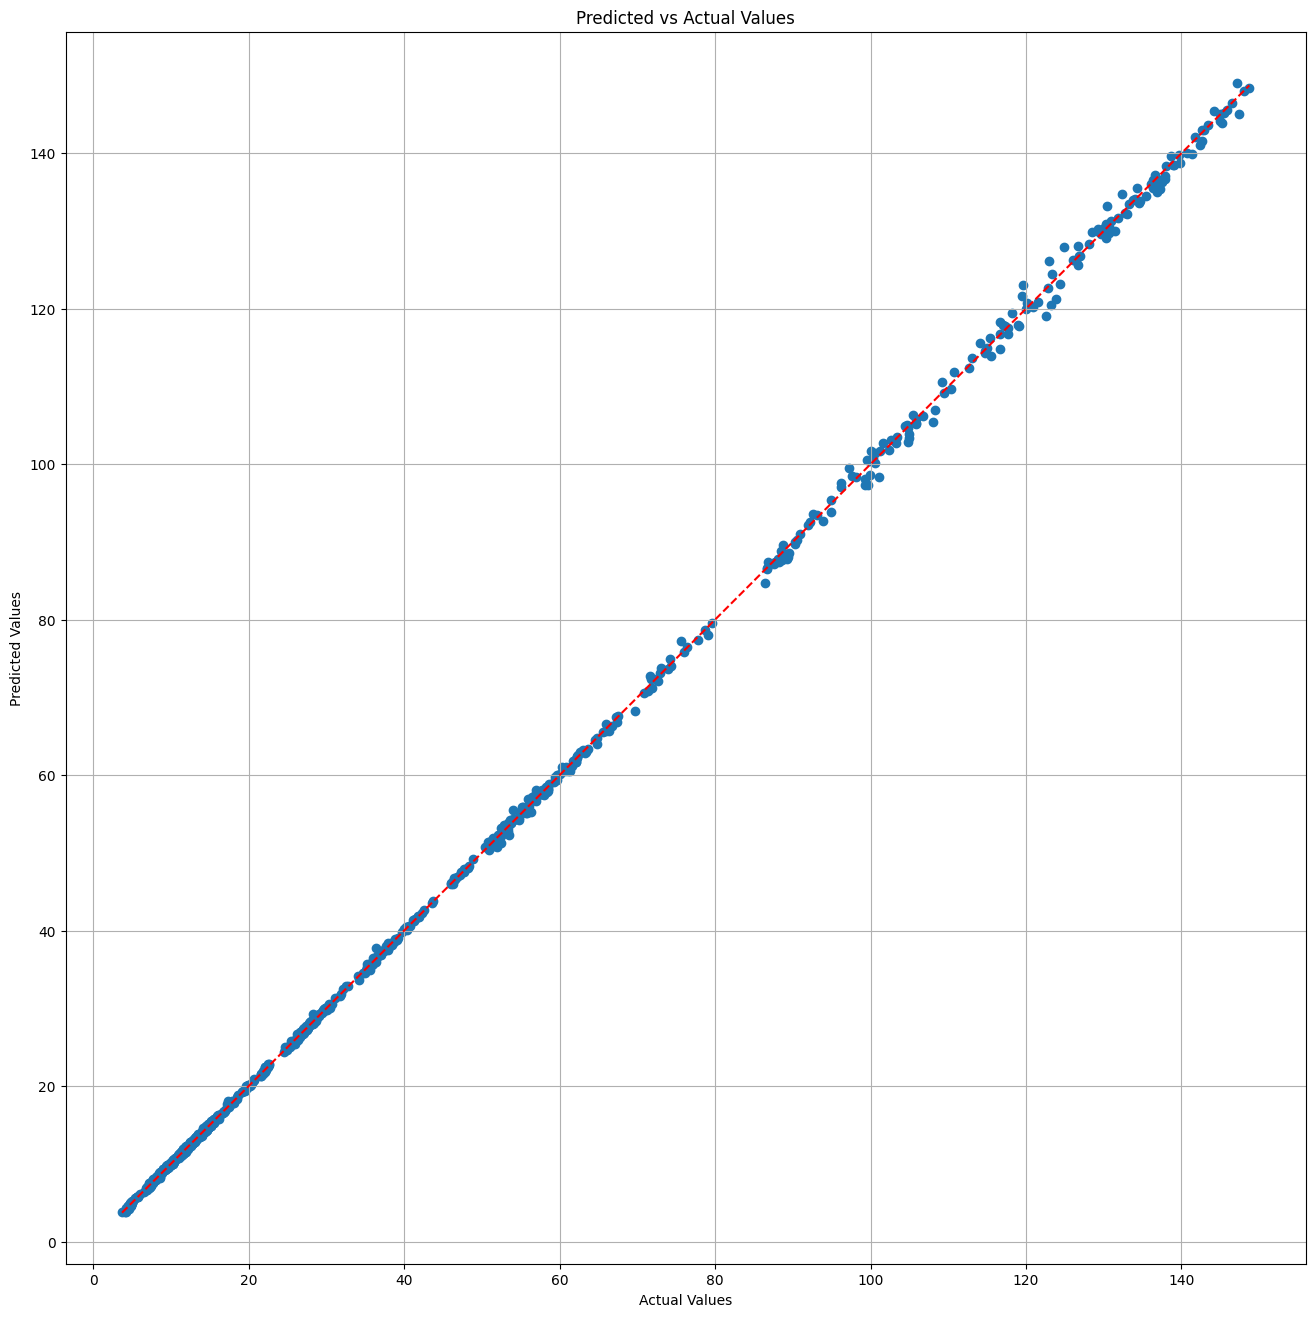

In [416]:
y_pred = y_preds[2]
plt.figure(figsize=(16, 16))
plt.scatter(y_test, y_pred, alpha=1)  # plot the predictions vs the actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # plot a 45-degree reference line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.axis('equal')  # Set equal scaling by changing axis limits
plt.show()